(page-learning)=
# Gradient Based Learning with Spiking Neurons

:::{note}
You can execute the code below by hitting <i class="fas fa-rocket"></i> above and pressing <i class="fas fa-play"></i> Live Code.
:::

## Surrogate or Pseudo Derivatives

In the time-discrete integration of spiking neuron equations, the heaviside function plays the role of a
threshhold detection function. Since the heaviside function $\Theta$ is only differentiable in the distributional sense,
a common way of sidestepping this issue is to introduce a parameterised function $\Theta_\alpha$ which converges
to $\Theta$ in some funciton space in the limit $\alpha \to \infty$ or $\alpha \to 0$ (depending on convention).

The idea is then to use the unmodified heaviside function in the threshold detection during forward integration and
the gradient of the approximation $\Theta'_\alpha$ during the backward integration.

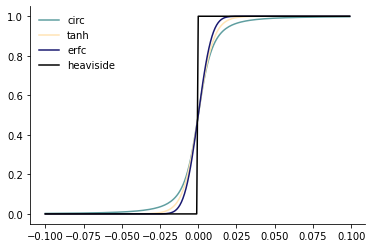

In [76]:
from norse.torch.functional.threshold import superspike_fn, heavi_circ_fn,  heavi_tanh_fn, heavi_erfc_fn

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['legend.frameon'] = False


def circ(x, alpha):
  return 0.5 + 0.5 * (x / (x.pow(2) + 1/alpha ** 2).sqrt())

def erfc(x, alpha):
  return 1.0 - 0.5 * torch.erfc(alpha * x)

def tanh(x, alpha):
  return 0.5 + 0.5 * torch.tanh(alpha * x)

functions = [
  (circ, 'circ', 100.0, 'cadetblue'),
  (tanh, 'tanh', 100.0, 'moccasin'),
  (erfc, 'erfc', 100.0, 'midnightblue'),
  (heavi_circ_fn, 'heaviside', 0.0, 'black')
]

xs = torch.tensor(np.arange(-0.1, 0.1, 0.001))
fig, ax = plt.subplots()

for (fn, label, alpha, color) in functions:
    ys = fn(xs, alpha)
    ax.plot(xs, ys, label=label, color=color)

ax.legend()

The convergence of the family of functions
$$
\text{circ}_\alpha(x) = \frac{1}{2} (1 + \frac{x}{\sqrt{x^2 + \alpha^2}})
$$
to the heaviside function can be visualised as follows

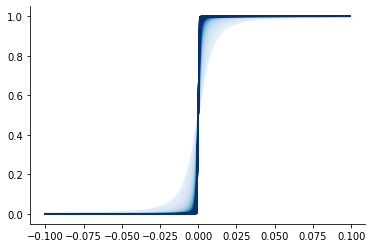

In [80]:
functions = [
    (circ, '', alpha, mpl.cm.Blues(alpha/1000)) for alpha in np.logspace(2,4)
]

xs = torch.tensor(np.arange(-0.1, 0.1, 0.001))
fig, ax = plt.subplots()

for (fn, label, alpha, color) in functions:
    ys = fn(xs, alpha)
    ax.plot(xs, ys, label=label, color=color)

We can also easily evaluate the corresponding derivative contributions as a function of the membrane voltage during the forward integration. All four visualised surrogate gradients propagate the gradient information through
if the membrane voltage $v$ was close to the threshhold $\theta$, that is if $v - \theta$ is close to zero. The scale at which this is true is set by the value of the hyperparameter $\alpha$. The following code visualises those gradients for four of the surrogate gradient functions that are implemented in the library.

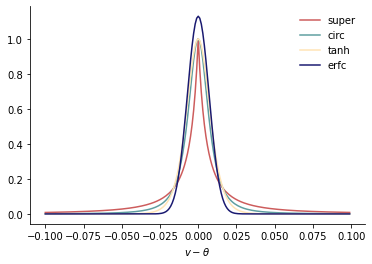

In [81]:
def eval_fn_and_grad(fn, xs, alpha):
    x = torch.tensor(xs, requires_grad=True)
    y = fn(x, alpha)
    y.backward(torch.ones_like(y))
    return y.detach().numpy(), x.grad.numpy()

surrogate_functions = [
  (superspike_fn, 'super', 100, 'indianred'),
  (heavi_circ_fn, 'circ', .01, 'cadetblue'),
  (heavi_tanh_fn, 'tanh', 100.0, 'moccasin'),
  (heavi_erfc_fn, 'erfc', 100.0, 'midnightblue'),
]

xs = np.arange(-.1, .1, 0.001)

fig, ax = plt.subplots()
for (fn, label, alpha, color) in surrogate_functions:
    y, dx = eval_fn_and_grad(fn, xs, alpha=torch.tensor(alpha))
    ax.plot(xs, dx, label=label, color=color)

ax.set_xlabel('$v - \\theta$')
_ = ax.legend()

And we can also visualise the dependence on the hyperparameter $\alpha$:

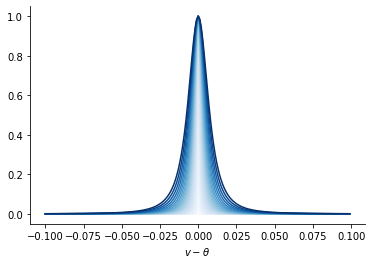

In [82]:
surrogate_functions = [
    (heavi_circ_fn, '', alpha, mpl.cm.Blues(alpha*100)) for alpha in np.logspace(-4,-2)
]

xs = np.arange(-.1, .1, 0.001)

fig, ax = plt.subplots()
for (fn, label, alpha, color) in surrogate_functions:
    y, dx = eval_fn_and_grad(fn, xs, alpha=torch.tensor(alpha))
    ax.plot(xs, dx, label=label, color=color)

_ = ax.set_xlabel('$v - \\theta$')